# Neural Network learns Compton Scattering

In Compton scattering, a photon collides with an electron, loses some of its energy and is
de ected from its original direction of travel.

The electron is assumed to be initially free and at rest - Klein and Nishina theory.For unpolarized photons, the Klein-Nishina angular distribution function is the following:

\begin{equation}
\frac{d \sigma}{d \Omega} = \frac{1}{2}r_0^2 \frac{E'^2}{E^2} \Big(  \frac{E'}{E} +\frac{E}{E'} - \sin(\theta)^2 \Big)
\end{equation}

Where $E$ is the initial photon energy, $E'$ is the final photon energy and $\theta$ is the scattering angle. Both $r_0$ and $m_e$ represent the radius and mass of the electron. The final photon energy can be obtained using the momentum and energy conservation equations:

\begin{equation}
E' = \frac{m_eE}{m_e + E - E\cos(\theta)}
\end{equation}


In [1]:
import pandas as pd 
import numpy as np
import math
import keras
import tensorflow as tf
import progressbar
import os
from os import listdir
from matplotlib import pyplot as plt
import random

### Compton Functions

In [2]:
def E_photon_final(E_photon_i, theta):
    me = 0.510998 #[MeV]
    E_photon_f = me*E_photon_i/(me + E_photon_i - E_photon_i*np.cos(theta))
    return E_photon_f

def finalCompton(E_photon_i,  theta):
    re_classical = 2.82 # [fm]
    
    E_photon_f = E_photon_final(E_photon_i, theta)
    E_fraction = E_photon_f / E_photon_i
    
    dSigma = 0.5*re_classical**2*1*E_fraction**2*(E_fraction + (1/E_fraction) - np.sin(theta)**2)
    
    return dSigma

In [3]:
E_photon_final(10,np.pi*0.1)

5.10776916826896

## Plotting and Balancing data functions

$\texttt{plot_history}$: Plots the loss function and the Kullback–Leibler divergence of every epoch. The Kullback–Leibler divergence measures the relative entropy between two probability distributions. When the probability for an event from one distribution is large, but the probability for the same event in another distribution is small, there is a large divergence. 


$\texttt{balance_data}$: This function allows us to create an equal amount of events of a given range of energy, by using the oversampling technique. 

In [4]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['kullback_leibler_divergence']
    val_accuracy = history.history['val_kullback_leibler_divergence']


    epochs = range(1, len(loss) + 1)
    fig, ax1 = plt.subplots()

    l1 = ax1.plot(epochs, loss, 'bo', label='Training loss')
    vl1 = ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (mape)')

    ax2 = ax1.twinx()
    ac2= ax2.plot(epochs, accuracy, 'o', c="red", label='Training KL div.')
    vac2= ax2.plot(epochs, val_accuracy, 'r', label='Validation KL div.')
    ax2.set_ylabel('Kullback Leibler divergence')

    lns = l1 + vl1 + ac2 + vac2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc="center right")
    fig.tight_layout()
    fig.show()
    

    
def balance_data(class_data, nbins):

    from matplotlib import pyplot as plt
    y = class_data[:,0]
    n, edges, _ = plt.hist(y, nbins, color = 'indianred', alpha=0.5, label='Osiris')
    n_max = int(n.max())
    data = []
    bar = progressbar.ProgressBar(maxval=len(class_data), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                       progressbar.Percentage(), 
                                       " of {0}".format(len(class_data))])
    bar.start()
    for k, class_ in enumerate(class_data):
        for i in range(len(n)):
            edges_min = edges[i]
            edges_max = edges[i+1]
            if class_[-1] > edges_min and class_[-1] < edges_max:
                for j in range(int(n_max/(n[i]))):
                    data.append(class_)
                break
        bar.update(k+1)
    bar.finish()

    return np.array(data)

# Creating and balacing the data set

In [5]:
def createDataSet(size, featPercentage):
    var = []

    for i in range(size):

        E_photon_i = random.uniform(0,100)
        theta = random.uniform(-np.pi,np.pi)
        var.append(np.array([E_photon_i, theta, finalCompton(E_photon_i,  theta)]))
    
    var = np.array(var)
    
    train_limit = int(len(var)*featPercentage)
    
    var_train = var[:train_limit, :]
    var_val = var[train_limit:,:]
    
    if np.isnan(np.min(var_train)) == False:
        return var_train, var_val

def createDataSet_wEnergy(size, energy):
    # TRAIN SET
    train_var = []
    train_target = []
    
    theta = np.linspace(-np.pi,np.pi, size)
    
    for i in range(size):
        train_var.append(np.array([energy, theta[i]]))

        train_target.append(finalCompton(energy,  theta[i]))
    
    train_var = np.array(train_var)
    train_target = np.array(train_target)
    
    if np.isnan(np.min(train_target)) == False:
        return train_var, train_target

[===============================================================] 100% of 85000


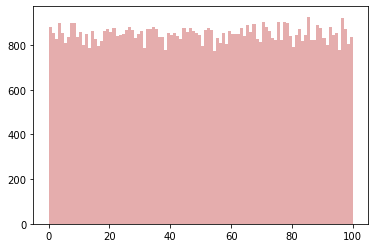

In [6]:
# features_train, target_train, features_val, target_val = createDataSet(100000, 0.85)
train, val = createDataSet(100000, 0.85)

balanced_feat_train = balance_data(train, 100)

In [7]:
print(balanced_feat_train.shape,
    val.shape)

(85000, 3) (15000, 3)


# Model Building

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from keras.layers.normalization import BatchNormalization

In [9]:
def build_model() :
    model = models.Sequential()
    model.add (BatchNormalization(input_dim = 2))
    model.add (layers.Dense (64 , activation = "relu"))
    model.add (layers.Dense (64 , activation = "relu"))
    model.add (layers.Dense (32 , activation = "relu"))
    model.add (layers.Dense (16 , activation = "relu"))
    model.add (layers.Dense (1 , activation = "selu"))
    model.compile(optimizer = "adam" , loss = 'mape' , metrics = ["mape",tf.keras.metrics.KLDivergence()])
    return model

In [10]:
print(train[:,:2].shape)

(85000, 2)


In [11]:
model = build_model()
history0 = model.fit( balanced_feat_train[:,:2], balanced_feat_train[:,2], 
                      epochs = 500, batch_size = 2000 , 
                      validation_data = (val[:,:2], val[:,2]) )

Epoch 1/500
43/43 [==============================] - 0s 10ms/step - loss: 75.2191 - mape: 75.2191 - kullback_leibler_divergence: 0.9234 - val_loss: 72.0520 - val_mape: 72.0520 - val_kullback_leibler_divergence: 0.5710
Epoch 2/500
43/43 [==============================] - 0s 4ms/step - loss: 39.3318 - mape: 39.3318 - kullback_leibler_divergence: 0.4664 - val_loss: 65.0162 - val_mape: 65.0162 - val_kullback_leibler_divergence: 0.4853
Epoch 3/500
43/43 [==============================] - 0s 4ms/step - loss: 33.5433 - mape: 33.5433 - kullback_leibler_divergence: 0.3546 - val_loss: 47.2905 - val_mape: 47.2905 - val_kullback_leibler_divergence: 0.3563
Epoch 4/500
43/43 [==============================] - 0s 4ms/step - loss: 27.4923 - mape: 27.4923 - kullback_leibler_divergence: 0.2625 - val_loss: 39.0221 - val_mape: 39.0221 - val_kullback_leibler_divergence: 0.2840
Epoch 5/500
43/43 [==============================] - 0s 4ms/step - loss: 24.7335 - mape: 24.7335 - kullback_leibler_divergence: 0.2

Epoch 76/500
43/43 [==============================] - 0s 4ms/step - loss: 11.5618 - mape: 11.5618 - kullback_leibler_divergence: 0.0131 - val_loss: 10.2486 - val_mape: 10.2486 - val_kullback_leibler_divergence: 0.0209
Epoch 77/500
43/43 [==============================] - 0s 4ms/step - loss: 10.8171 - mape: 10.8171 - kullback_leibler_divergence: 0.0118 - val_loss: 9.7569 - val_mape: 9.7569 - val_kullback_leibler_divergence: 0.0180
Epoch 78/500
43/43 [==============================] - 0s 4ms/step - loss: 11.5501 - mape: 11.5501 - kullback_leibler_divergence: 0.0119 - val_loss: 6.5525 - val_mape: 6.5525 - val_kullback_leibler_divergence: 0.0127
Epoch 79/500
43/43 [==============================] - 0s 4ms/step - loss: 10.0606 - mape: 10.0606 - kullback_leibler_divergence: 0.0092 - val_loss: 7.2968 - val_mape: 7.2968 - val_kullback_leibler_divergence: 0.0065
Epoch 80/500
43/43 [==============================] - 0s 4ms/step - loss: 9.5427 - mape: 9.5427 - kullback_leibler_divergence: 0.0092 

Epoch 114/500
43/43 [==============================] - 0s 4ms/step - loss: 10.3011 - mape: 10.3011 - kullback_leibler_divergence: 0.0107 - val_loss: 5.9215 - val_mape: 5.9215 - val_kullback_leibler_divergence: 0.0085
Epoch 115/500
43/43 [==============================] - 0s 4ms/step - loss: 9.3508 - mape: 9.3508 - kullback_leibler_divergence: 0.0085 - val_loss: 6.0876 - val_mape: 6.0876 - val_kullback_leibler_divergence: 0.0113
Epoch 116/500
43/43 [==============================] - 0s 4ms/step - loss: 10.4860 - mape: 10.4860 - kullback_leibler_divergence: 0.0107 - val_loss: 6.1974 - val_mape: 6.1974 - val_kullback_leibler_divergence: 0.0023
Epoch 117/500
43/43 [==============================] - 0s 4ms/step - loss: 8.7389 - mape: 8.7389 - kullback_leibler_divergence: 0.0078 - val_loss: 5.4693 - val_mape: 5.4693 - val_kullback_leibler_divergence: 0.0090
Epoch 118/500
43/43 [==============================] - 0s 4ms/step - loss: 9.2036 - mape: 9.2036 - kullback_leibler_divergence: 0.0088 -

Epoch 152/500
43/43 [==============================] - 0s 4ms/step - loss: 9.7655 - mape: 9.7655 - kullback_leibler_divergence: 0.0078 - val_loss: 7.7995 - val_mape: 7.7995 - val_kullback_leibler_divergence: 0.0179
Epoch 153/500
43/43 [==============================] - ETA: 0s - loss: 10.3973 - mape: 10.3973 - kullback_leibler_divergence: 0.01 - 0s 4ms/step - loss: 9.8848 - mape: 9.8848 - kullback_leibler_divergence: 0.0101 - val_loss: 7.0088 - val_mape: 7.0088 - val_kullback_leibler_divergence: 0.0073
Epoch 154/500
43/43 [==============================] - 0s 4ms/step - loss: 8.8040 - mape: 8.8040 - kullback_leibler_divergence: 0.0071 - val_loss: 6.3844 - val_mape: 6.3844 - val_kullback_leibler_divergence: 0.0099
Epoch 155/500
43/43 [==============================] - 0s 4ms/step - loss: 9.9900 - mape: 9.9900 - kullback_leibler_divergence: 0.0094 - val_loss: 8.7414 - val_mape: 8.7414 - val_kullback_leibler_divergence: 0.0147
Epoch 156/500
43/43 [==============================] - 0s 4ms/

Epoch 227/500
43/43 [==============================] - 0s 4ms/step - loss: 9.4078 - mape: 9.4078 - kullback_leibler_divergence: 0.0094 - val_loss: 7.0868 - val_mape: 7.0868 - val_kullback_leibler_divergence: 0.0038
Epoch 228/500
43/43 [==============================] - 0s 4ms/step - loss: 10.0159 - mape: 10.0159 - kullback_leibler_divergence: 0.0091 - val_loss: 7.1606 - val_mape: 7.1606 - val_kullback_leibler_divergence: 0.0095
Epoch 229/500
43/43 [==============================] - 0s 4ms/step - loss: 10.3628 - mape: 10.3628 - kullback_leibler_divergence: 0.0086 - val_loss: 6.3255 - val_mape: 6.3255 - val_kullback_leibler_divergence: 0.0060
Epoch 230/500
43/43 [==============================] - 0s 4ms/step - loss: 9.8017 - mape: 9.8017 - kullback_leibler_divergence: 0.0078 - val_loss: 9.3694 - val_mape: 9.3694 - val_kullback_leibler_divergence: 0.0178
Epoch 231/500
43/43 [==============================] - 0s 4ms/step - loss: 9.2359 - mape: 9.2359 - kullback_leibler_divergence: 0.0078 -

Epoch 265/500
43/43 [==============================] - 0s 4ms/step - loss: 9.8463 - mape: 9.8463 - kullback_leibler_divergence: 0.0059 - val_loss: 6.7979 - val_mape: 6.7979 - val_kullback_leibler_divergence: 0.0129
Epoch 266/500
43/43 [==============================] - 0s 4ms/step - loss: 10.1958 - mape: 10.1958 - kullback_leibler_divergence: 0.0087 - val_loss: 7.5434 - val_mape: 7.5434 - val_kullback_leibler_divergence: 0.0126
Epoch 267/500
43/43 [==============================] - 0s 4ms/step - loss: 9.9244 - mape: 9.9244 - kullback_leibler_divergence: 0.0082 - val_loss: 4.6872 - val_mape: 4.6872 - val_kullback_leibler_divergence: -4.5358e-04
Epoch 268/500
43/43 [==============================] - 0s 4ms/step - loss: 7.9618 - mape: 7.9618 - kullback_leibler_divergence: 0.0058 - val_loss: 4.8716 - val_mape: 4.8716 - val_kullback_leibler_divergence: 0.0029
Epoch 269/500
43/43 [==============================] - 0s 4ms/step - loss: 9.5046 - mape: 9.5046 - kullback_leibler_divergence: 0.007

Epoch 303/500
43/43 [==============================] - 0s 4ms/step - loss: 11.4591 - mape: 11.4591 - kullback_leibler_divergence: 0.0142 - val_loss: 8.5192 - val_mape: 8.5192 - val_kullback_leibler_divergence: 0.0151
Epoch 304/500
43/43 [==============================] - 0s 4ms/step - loss: 8.8513 - mape: 8.8513 - kullback_leibler_divergence: 0.0077 - val_loss: 4.7005 - val_mape: 4.7005 - val_kullback_leibler_divergence: 0.0074
Epoch 305/500
43/43 [==============================] - 0s 5ms/step - loss: 9.4148 - mape: 9.4148 - kullback_leibler_divergence: 0.0092 - val_loss: 5.3316 - val_mape: 5.3316 - val_kullback_leibler_divergence: 0.0121
Epoch 306/500
43/43 [==============================] - 0s 5ms/step - loss: 8.2686 - mape: 8.2686 - kullback_leibler_divergence: 0.0058 - val_loss: 4.7038 - val_mape: 4.7038 - val_kullback_leibler_divergence: 0.0051
Epoch 307/500
43/43 [==============================] - 0s 5ms/step - loss: 9.2330 - mape: 9.2330 - kullback_leibler_divergence: 0.0076 - v

Epoch 341/500
43/43 [==============================] - 0s 4ms/step - loss: 8.8172 - mape: 8.8172 - kullback_leibler_divergence: 0.0072 - val_loss: 3.7266 - val_mape: 3.7266 - val_kullback_leibler_divergence: 0.0053
Epoch 342/500
43/43 [==============================] - 0s 4ms/step - loss: 9.0467 - mape: 9.0467 - kullback_leibler_divergence: 0.0072 - val_loss: 6.4408 - val_mape: 6.4408 - val_kullback_leibler_divergence: -0.0013
Epoch 343/500
43/43 [==============================] - 0s 4ms/step - loss: 10.0492 - mape: 10.0492 - kullback_leibler_divergence: 0.0093 - val_loss: 5.8217 - val_mape: 5.8217 - val_kullback_leibler_divergence: 0.0029
Epoch 344/500
43/43 [==============================] - 0s 4ms/step - loss: 9.4036 - mape: 9.4036 - kullback_leibler_divergence: 0.0072 - val_loss: 4.4197 - val_mape: 4.4197 - val_kullback_leibler_divergence: 0.0074
Epoch 345/500
43/43 [==============================] - 0s 4ms/step - loss: 8.1856 - mape: 8.1856 - kullback_leibler_divergence: 0.0060 - 

Epoch 379/500
43/43 [==============================] - 0s 4ms/step - loss: 9.4387 - mape: 9.4387 - kullback_leibler_divergence: 0.0094 - val_loss: 4.3937 - val_mape: 4.3937 - val_kullback_leibler_divergence: 0.0089
Epoch 380/500
43/43 [==============================] - 0s 4ms/step - loss: 9.1480 - mape: 9.1480 - kullback_leibler_divergence: 0.0081 - val_loss: 5.3696 - val_mape: 5.3696 - val_kullback_leibler_divergence: 0.0058
Epoch 381/500
43/43 [==============================] - 0s 4ms/step - loss: 8.1992 - mape: 8.1992 - kullback_leibler_divergence: 0.0047 - val_loss: 4.8972 - val_mape: 4.8972 - val_kullback_leibler_divergence: 0.0047
Epoch 382/500
43/43 [==============================] - 0s 4ms/step - loss: 8.6664 - mape: 8.6664 - kullback_leibler_divergence: 0.0080 - val_loss: 4.1737 - val_mape: 4.1737 - val_kullback_leibler_divergence: 0.0033
Epoch 383/500
43/43 [==============================] - 0s 4ms/step - loss: 9.3787 - mape: 9.3787 - kullback_leibler_divergence: 0.0083 - val

43/43 [==============================] - 0s 4ms/step - loss: 8.5005 - mape: 8.5005 - kullback_leibler_divergence: 0.0077 - val_loss: 3.4779 - val_mape: 3.4779 - val_kullback_leibler_divergence: 0.0047
Epoch 418/500
43/43 [==============================] - 0s 4ms/step - loss: 8.4118 - mape: 8.4118 - kullback_leibler_divergence: 0.0067 - val_loss: 4.6523 - val_mape: 4.6523 - val_kullback_leibler_divergence: 0.0099
Epoch 419/500
43/43 [==============================] - 0s 4ms/step - loss: 8.8757 - mape: 8.8757 - kullback_leibler_divergence: 0.0084 - val_loss: 3.5495 - val_mape: 3.5495 - val_kullback_leibler_divergence: -0.0023
Epoch 420/500
43/43 [==============================] - 0s 4ms/step - loss: 8.8480 - mape: 8.8480 - kullback_leibler_divergence: 0.0079 - val_loss: 4.6846 - val_mape: 4.6846 - val_kullback_leibler_divergence: 0.0090
Epoch 421/500
43/43 [==============================] - 0s 4ms/step - loss: 9.1356 - mape: 9.1356 - kullback_leibler_divergence: 0.0070 - val_loss: 6.5162

43/43 [==============================] - 0s 4ms/step - loss: 9.6551 - mape: 9.6551 - kullback_leibler_divergence: 0.0091 - val_loss: 7.0365 - val_mape: 7.0365 - val_kullback_leibler_divergence: 0.0160
Epoch 493/500
43/43 [==============================] - 0s 4ms/step - loss: 9.8512 - mape: 9.8512 - kullback_leibler_divergence: 0.0103 - val_loss: 4.9500 - val_mape: 4.9500 - val_kullback_leibler_divergence: -0.0015
Epoch 494/500
43/43 [==============================] - 0s 4ms/step - loss: 9.2564 - mape: 9.2564 - kullback_leibler_divergence: 0.0101 - val_loss: 4.5300 - val_mape: 4.5300 - val_kullback_leibler_divergence: 0.0083
Epoch 495/500
43/43 [==============================] - 0s 4ms/step - loss: 8.2697 - mape: 8.2697 - kullback_leibler_divergence: 0.0058 - val_loss: 6.1727 - val_mape: 6.1727 - val_kullback_leibler_divergence: 0.0113
Epoch 496/500
43/43 [==============================] - 0s 4ms/step - loss: 8.5169 - mape: 8.5169 - kullback_leibler_divergence: 0.0097 - val_loss: 6.5271

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/684719804.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


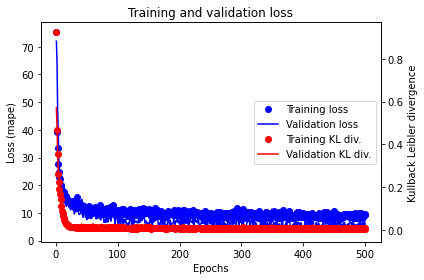

In [12]:
plot_history(history0)

# Prediction

In [13]:
y_pred0 = model.predict(val[:,:2])

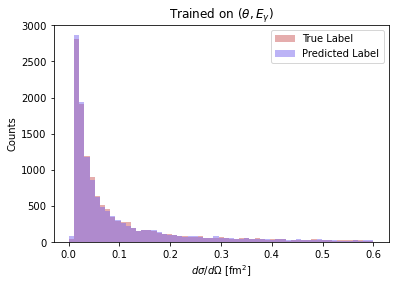

In [14]:
from matplotlib import pyplot
y0_val = np.array(val[:,2])
bins = np.linspace(0.0004, 0.6, 60)
pyplot.hist(y0_val, bins, color = 'indianred', alpha=0.5, label='True Label')
pyplot.hist(y_pred0, bins, color = 'mediumslateblue', alpha=0.5, label='Predicted Label')
#pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.xlabel('$d \sigma / d\Omega$ [fm$^2$]')
pyplot.ylabel('Counts')
pyplot.title('Trained on ($ \\theta , E_{\gamma}$)')
pyplot.show()

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/1437903866.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax=fig.gca(polar=True)


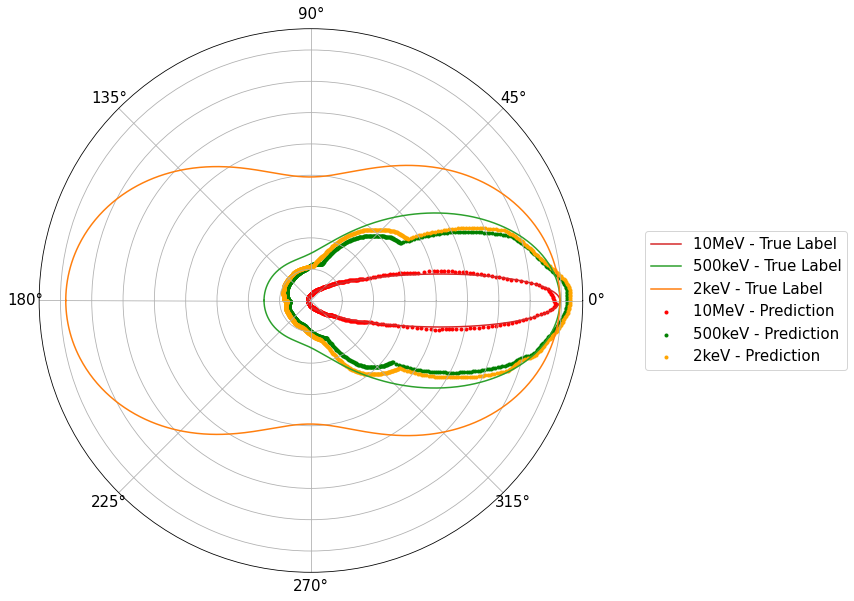

In [15]:
plt.rc('font', size=15)


features_E10, true_targets_E10 = createDataSet_wEnergy(1000, 10)
pred_targets_E10 = model.predict(features_E10)

features_E1, true_targets_E1 = createDataSet_wEnergy(1000, 1)
pred_targets_E1 = model.predict(features_E1)

features_E006, true_targets_E006 = createDataSet_wEnergy(1000, 0.5)
pred_targets_E006 = model.predict(features_E006)

features_E0002, true_targets_E0002 = createDataSet_wEnergy(1000, 0.002)
pred_targets_E0002 = model.predict(features_E0002)

fig=plt.figure(figsize=[10,10])
ax=fig.gca(polar=True)

ax.scatter(features_E10[:,1], pred_targets_E10,marker='.', label='10MeV - Prediction', c='red')
ax.plot(features_E10[:,1], true_targets_E10, label='10MeV - True Label', c='tab:red')

# ax.scatter(features_E1[:,1], pred_targets_E1,marker='.', label='1MeV - Prediction', c='b')
# ax.plot(features_E1[:,1], true_targets_E1, label='1MeV - True Label', c='tab:blue')

ax.scatter(features_E006[:,1], pred_targets_E006,marker='.', label='500keV - Prediction', c='g')
ax.plot(features_E006[:,1], true_targets_E006, label='500keV - True Label', c='tab:green')

ax.scatter(features_E0002[:,1], pred_targets_E0002,marker='.', label='2keV - Prediction', c='orange')
ax.plot(features_E0002[:,1], true_targets_E0002, label='2keV - True Label', c='tab:orange')

ax.set_yticklabels([])
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('KN_angular_dist_balanced.png',bbox_inches='tight')
plt.show()

# Transfer Learning

Transfer Learnig is a machine learning method where the developed model for a task is retrained as the starting point for a second task.

We will divide the data set into four different intervals of energy: [0,20keV], [20,500keV], [500keV, 10MeV], [10MeV, 100MeV]. The model will first be trained using one of the data sets, then the model is saved and used as a starting point to the next range of energies.

In [16]:
def createDataSet_IntervalEnergy(size, featPercentage, Emin, Emax):
    var = []

    for i in range(size):

        E_photon_i = random.uniform(Emin, Emax)
        theta = random.uniform(-np.pi,np.pi)
        var.append(np.array([E_photon_i, theta, finalCompton(E_photon_i,  theta)]))
    
    var = np.array(var)
    
    train_limit = int(len(var)*featPercentage)
    
    var_train = var[:train_limit, :]
    var_val = var[train_limit:,:]
    
    if np.isnan(np.min(var_train)) == False:
        return var_train, var_val

## $E \in [0 \text{keV}, 2 \text{keV}]$

In [17]:
plt.rc('font', size=10)

TL1_train, TL1_val = createDataSet_IntervalEnergy(100000, 0.85, 0, 0.002)

# TL1_feat_train = balance_data(TL1_train, 100)

In [18]:
model_TL = build_model()
historyTL1 = model_TL.fit( TL1_train[:,:2], TL1_train[:,2], 
                      epochs = 100, batch_size = 1000 , 
                      validation_data = (TL1_val[:,:2], TL1_val[:,2]) )

Epoch 1/100
85/85 [==============================] - 0s 5ms/step - loss: 55.7698 - mape: 55.7698 - kullback_leibler_divergence: 0.6647 - val_loss: 28.2792 - val_mape: 28.2792 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 2/100
85/85 [==============================] - 0s 3ms/step - loss: 20.1059 - mape: 20.1059 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 17.2831 - val_mape: 17.2831 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 12.8494 - mape: 12.8494 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 8.7320 - val_mape: 8.7320 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 6.3910 - mape: 6.3910 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 3.8610 - val_mape: 3.8610 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 4.4983 - mape: 4.4983 - kullback_leib

Epoch 38/100
85/85 [==============================] - 0s 3ms/step - loss: 3.0441 - mape: 3.0441 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.4434 - val_mape: 1.4434 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 39/100
85/85 [==============================] - 0s 3ms/step - loss: 2.7908 - mape: 2.7908 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.7919 - val_mape: 1.7919 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 40/100
85/85 [==============================] - 0s 3ms/step - loss: 3.1289 - mape: 3.1289 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.4132 - val_mape: 1.4132 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 41/100
85/85 [==============================] - 0s 3ms/step - loss: 2.9160 - mape: 2.9160 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.6282 - val_mape: 1.6282 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 42/100
85/85 [==============================] - 0s 3ms/step - loss: 3.0767 - mape: 3.0767 - kullback_leibl

Epoch 75/100
85/85 [==============================] - 0s 3ms/step - loss: 2.9762 - mape: 2.9762 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.2528 - val_mape: 1.2528 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 76/100
85/85 [==============================] - 0s 3ms/step - loss: 2.9235 - mape: 2.9235 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.8239 - val_mape: 1.8239 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 77/100
85/85 [==============================] - 0s 3ms/step - loss: 3.1104 - mape: 3.1104 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 2.2691 - val_mape: 2.2691 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 78/100
85/85 [==============================] - 0s 3ms/step - loss: 2.8518 - mape: 2.8518 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 2.4477 - val_mape: 2.4477 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 79/100
85/85 [==============================] - 0s 3ms/step - loss: 2.9905 - mape: 2.9905 - kullback_leibl

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/684719804.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


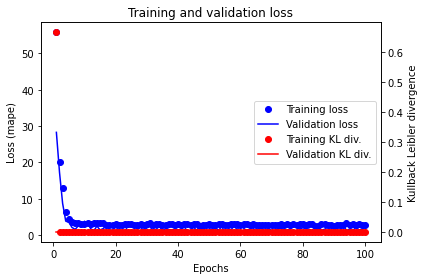

In [19]:
model_TL.save("./models/{}.h5".format('transferlearning1'))
plot_history(historyTL1)

In [20]:
features_E0002, true_targets_E0002 = createDataSet_wEnergy(1000, 0.002)
pred_targets_E0002 = model_TL.predict(features_E0002)

## $E \in [2 \text{keV}, 500\text{keV}]$

In [21]:
TL2_train, TL2_val = createDataSet_IntervalEnergy(100000, 0.85, 0.002,0.5 )

# TL2_feat_train = balance_data(TL2_train, 100)

In [22]:
model_TL.trainable = True

historyTL2 = model_TL.fit( TL2_train[:,:2], TL2_train[:,2], 
                          epochs = 200, initial_epoch=100,
                          batch_size = 1000 ,
                          validation_data = (TL2_val[:,:2], TL2_val[:,2]) )

Epoch 101/200
85/85 [==============================] - 0s 3ms/step - loss: 27.2052 - mape: 27.2052 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 20.6980 - val_mape: 20.6980 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 102/200
85/85 [==============================] - 0s 3ms/step - loss: 11.3421 - mape: 11.3421 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 9.9612 - val_mape: 9.9612 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 103/200
85/85 [==============================] - 0s 3ms/step - loss: 7.4695 - mape: 7.4695 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 5.9333 - val_mape: 5.9333 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 104/200
85/85 [==============================] - 0s 3ms/step - loss: 5.6727 - mape: 5.6727 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 4.7969 - val_mape: 4.7969 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 105/200
85/85 [==============================] - 0s 3ms/step - loss: 5.6084 - mape: 5.6084 - kul

Epoch 174/200
85/85 [==============================] - 0s 3ms/step - loss: 3.0392 - mape: 3.0392 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.5335 - val_mape: 1.5335 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 175/200
85/85 [==============================] - 0s 3ms/step - loss: 3.1374 - mape: 3.1374 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 2.4097 - val_mape: 2.4097 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 176/200
85/85 [==============================] - 0s 3ms/step - loss: 3.2193 - mape: 3.2193 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.6630 - val_mape: 1.6630 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 177/200
85/85 [==============================] - 0s 3ms/step - loss: 3.5220 - mape: 3.5220 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.2341 - val_mape: 1.2341 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 178/200
85/85 [==============================] - 0s 3ms/step - loss: 2.9172 - mape: 2.9172 - kullback_

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/684719804.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


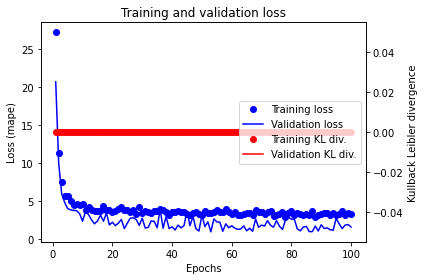

In [23]:
model_TL.save("./models/{}.h5".format('transferlearning2'))
plot_history(historyTL2)

In [24]:
features_E006, true_targets_E006 = createDataSet_wEnergy(1000, 0.5)
pred_targets_E006 = model_TL.predict(features_E006)

## $E \in [500\text{keV}, 10 \text{MeV}]$

In [25]:
TL3_train, TL3_val = createDataSet_IntervalEnergy(100000, 0.85, 0.5, 10)

# TL3_feat_train = balance_data(TL3_train, 100)

In [26]:
historyTL3 = model_TL.fit( TL3_train[:,:2], TL3_train[:,2], 
                          epochs = 300, initial_epoch=200,
                          batch_size = 1000 ,
                          validation_data = (TL3_val[:,:2], TL3_val[:,2]) )

Epoch 201/300
85/85 [==============================] - 0s 3ms/step - loss: 64.5504 - mape: 64.5504 - kullback_leibler_divergence: 0.1762 - val_loss: 34.1933 - val_mape: 34.1933 - val_kullback_leibler_divergence: 0.1559
Epoch 202/300
85/85 [==============================] - 0s 3ms/step - loss: 13.9197 - mape: 13.9197 - kullback_leibler_divergence: 0.0117 - val_loss: 16.5318 - val_mape: 16.5318 - val_kullback_leibler_divergence: 0.0536
Epoch 203/300
85/85 [==============================] - 0s 3ms/step - loss: 10.4036 - mape: 10.4036 - kullback_leibler_divergence: 0.0092 - val_loss: 10.2851 - val_mape: 10.2851 - val_kullback_leibler_divergence: 0.0317
Epoch 204/300
85/85 [==============================] - 0s 3ms/step - loss: 8.7214 - mape: 8.7214 - kullback_leibler_divergence: 0.0056 - val_loss: 5.4080 - val_mape: 5.4080 - val_kullback_leibler_divergence: 0.0074
Epoch 205/300
85/85 [==============================] - 0s 3ms/step - loss: 8.8718 - mape: 8.8718 - kullback_leibler_divergence: 

Epoch 238/300
85/85 [==============================] - 0s 3ms/step - loss: 7.5167 - mape: 7.5167 - kullback_leibler_divergence: 0.0026 - val_loss: 3.5690 - val_mape: 3.5690 - val_kullback_leibler_divergence: 0.0053
Epoch 239/300
85/85 [==============================] - 0s 3ms/step - loss: 7.0563 - mape: 7.0563 - kullback_leibler_divergence: 0.0020 - val_loss: 2.1707 - val_mape: 2.1707 - val_kullback_leibler_divergence: 0.0043
Epoch 240/300
85/85 [==============================] - 0s 3ms/step - loss: 6.9342 - mape: 6.9342 - kullback_leibler_divergence: 0.0025 - val_loss: 3.6634 - val_mape: 3.6634 - val_kullback_leibler_divergence: 0.0039
Epoch 241/300
85/85 [==============================] - 0s 3ms/step - loss: 7.3204 - mape: 7.3204 - kullback_leibler_divergence: 0.0012 - val_loss: 3.4559 - val_mape: 3.4559 - val_kullback_leibler_divergence: 0.0067
Epoch 242/300
85/85 [==============================] - 0s 3ms/step - loss: 6.9601 - mape: 6.9601 - kullback_leibler_divergence: 0.0032 - val

Epoch 276/300
85/85 [==============================] - 0s 3ms/step - loss: 7.6409 - mape: 7.6409 - kullback_leibler_divergence: 0.0049 - val_loss: 5.2403 - val_mape: 5.2403 - val_kullback_leibler_divergence: 0.0015
Epoch 277/300
85/85 [==============================] - 0s 3ms/step - loss: 6.8493 - mape: 6.8493 - kullback_leibler_divergence: 0.0021 - val_loss: 6.1822 - val_mape: 6.1822 - val_kullback_leibler_divergence: -0.0082
Epoch 278/300
85/85 [==============================] - 0s 3ms/step - loss: 7.5265 - mape: 7.5265 - kullback_leibler_divergence: 0.0018 - val_loss: 4.5071 - val_mape: 4.5071 - val_kullback_leibler_divergence: -0.0023
Epoch 279/300
85/85 [==============================] - 0s 3ms/step - loss: 7.3424 - mape: 7.3424 - kullback_leibler_divergence: 0.0020 - val_loss: 3.5562 - val_mape: 3.5562 - val_kullback_leibler_divergence: -0.0093
Epoch 280/300
85/85 [==============================] - 0s 3ms/step - loss: 6.9666 - mape: 6.9666 - kullback_leibler_divergence: 0.0018 - 

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/684719804.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


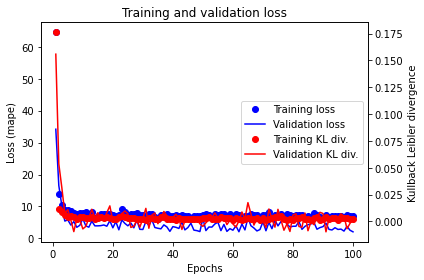

In [27]:
model_TL.save("./models/{}.h5".format('transferlearning3'))
plot_history(historyTL3)

In [28]:
features_E1, true_targets_E1 = createDataSet_wEnergy(1000, 1)
pred_targets_E1 = model_TL.predict(features_E1)

## $E \in [ 10 \text{MeV},  100 \text{MeV}]$

In [29]:
TL4_train, TL4_val = createDataSet_IntervalEnergy(100000, 0.85, 10, 100)

# TL4_feat_train = balance_data(TL4_train, 100)

In [30]:
historyTL4 = model_TL.fit( TL4_train[:,:2], TL4_train[:,2], 
                          epochs = 400, initial_epoch=300,
                          batch_size = 1000 ,
                          validation_data = (TL4_val[:,:2], TL4_val[:,2]) )

Epoch 301/400
85/85 [==============================] - 0s 3ms/step - loss: 89.6758 - mape: 89.6758 - kullback_leibler_divergence: 0.1199 - val_loss: 46.3091 - val_mape: 46.3091 - val_kullback_leibler_divergence: 0.1569
Epoch 302/400
85/85 [==============================] - 0s 3ms/step - loss: 22.5728 - mape: 22.5728 - kullback_leibler_divergence: 0.0277 - val_loss: 22.7981 - val_mape: 22.7981 - val_kullback_leibler_divergence: 0.0291
Epoch 303/400
85/85 [==============================] - 0s 3ms/step - loss: 16.2600 - mape: 16.2600 - kullback_leibler_divergence: 0.0139 - val_loss: 13.6264 - val_mape: 13.6264 - val_kullback_leibler_divergence: 0.0160
Epoch 304/400
85/85 [==============================] - 0s 3ms/step - loss: 14.0676 - mape: 14.0676 - kullback_leibler_divergence: 0.0097 - val_loss: 8.6182 - val_mape: 8.6182 - val_kullback_leibler_divergence: 0.0099
Epoch 305/400
85/85 [==============================] - 0s 3ms/step - loss: 13.2085 - mape: 13.2085 - kullback_leibler_divergen

Epoch 376/400
85/85 [==============================] - 0s 3ms/step - loss: 10.7372 - mape: 10.7372 - kullback_leibler_divergence: 0.0085 - val_loss: 5.9952 - val_mape: 5.9952 - val_kullback_leibler_divergence: -7.1946e-04
Epoch 377/400
85/85 [==============================] - 0s 3ms/step - loss: 10.9481 - mape: 10.9481 - kullback_leibler_divergence: 0.0095 - val_loss: 6.6737 - val_mape: 6.6737 - val_kullback_leibler_divergence: 0.0117
Epoch 378/400
85/85 [==============================] - 0s 3ms/step - loss: 10.1168 - mape: 10.1168 - kullback_leibler_divergence: 0.0076 - val_loss: 8.1749 - val_mape: 8.1749 - val_kullback_leibler_divergence: 0.0013
Epoch 379/400
85/85 [==============================] - 0s 3ms/step - loss: 10.8303 - mape: 10.8303 - kullback_leibler_divergence: 0.0059 - val_loss: 8.0020 - val_mape: 8.0020 - val_kullback_leibler_divergence: 0.0067
Epoch 380/400
85/85 [==============================] - 0s 3ms/step - loss: 10.9297 - mape: 10.9297 - kullback_leibler_divergenc

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/684719804.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


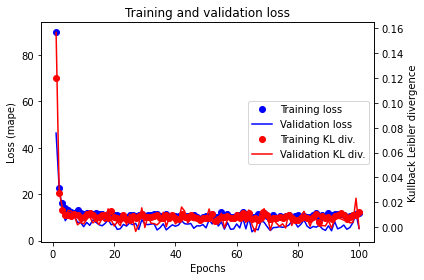

In [31]:
model_TL.save("./models/{}.h5".format('transferlearning4'))
plot_history(historyTL4)

C:\Users\luisr\AppData\Local\Temp/ipykernel_10852/834106211.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax=fig.gca(polar=True)


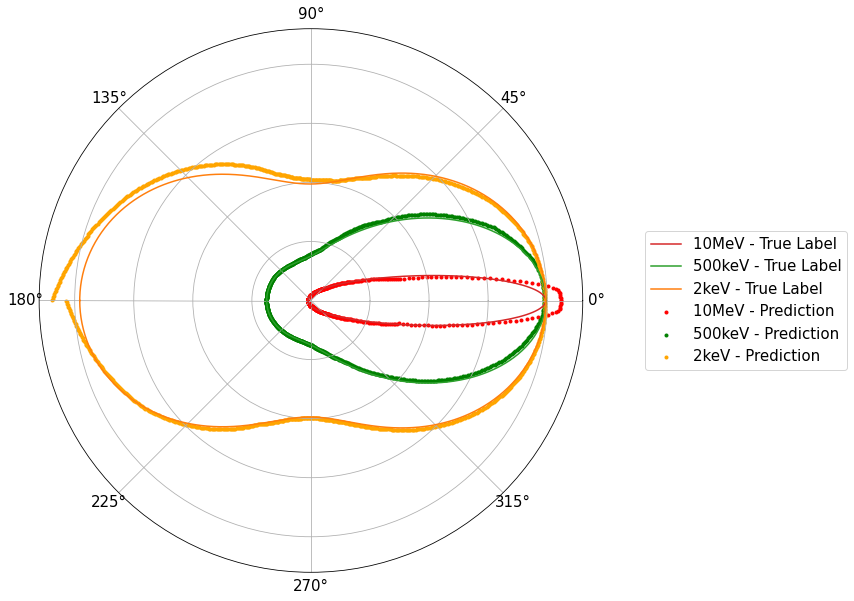

In [32]:
plt.rc('font', size=15)

features_E10, true_targets_E10 = createDataSet_wEnergy(1000, 10)
pred_targets_E10 = model_TL.predict(features_E10)


fig=plt.figure(figsize=[10,10])
ax=fig.gca(polar=True)

ax.scatter(features_E10[:,1], pred_targets_E10,marker='.', label='10MeV - Prediction', c='red')
ax.plot(features_E10[:,1], true_targets_E10, label='10MeV - True Label', c='tab:red')

# ax.scatter(features_E1[:,1], pred_targets_E1,marker='.', label='1MeV - Prediction', c='b')
# ax.plot(features_E1[:,1], true_targets_E1, label='1MeV - True Label', c='tab:blue')

ax.scatter(features_E006[:,1], pred_targets_E006,marker='.', label='500keV - Prediction', c='g')
ax.plot(features_E006[:,1], true_targets_E006, label='500keV - True Label', c='tab:green')

ax.scatter(features_E0002[:,1], pred_targets_E0002,marker='.', label='2keV - Prediction', c='orange')
ax.plot(features_E0002[:,1], true_targets_E0002, label='2keV - True Label', c='tab:orange')

ax.set_yticklabels([])
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('KN_angular_dist_TL.png',bbox_inches='tight')
plt.show()